Epoch [10/50], Loss: 38216.1891
Epoch [20/50], Loss: 15237.0949
Epoch [30/50], Loss: 9385.3727
Epoch [40/50], Loss: 7591.6303
Epoch [50/50], Loss: 6552.0862

PYTORCH MLP MODEL PERFORMANCE
MAE:  72.959
RMSE: 98.776
R²:   0.991


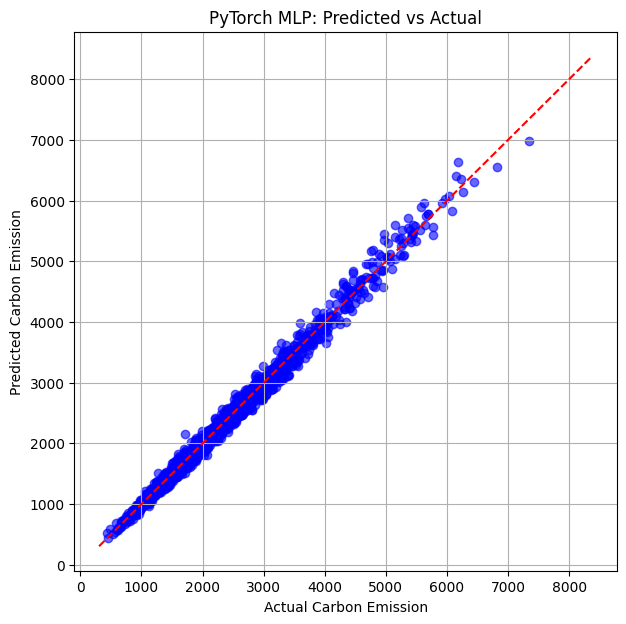

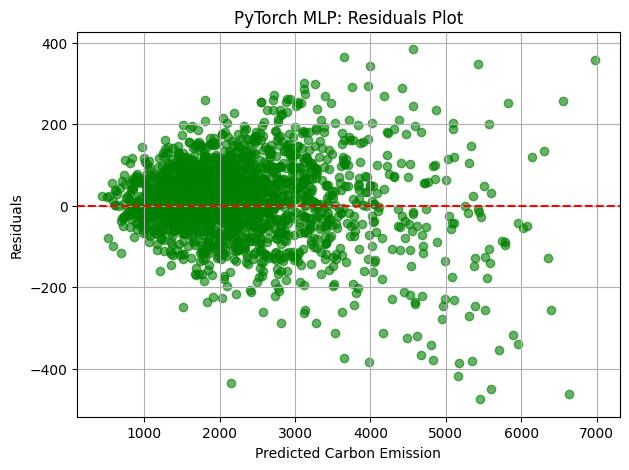

In [3]:
# ============================================
#  CARBON EMISSION PREDICTION — PYTORCH MLP MODEL
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# ----------------------------
# 1. LOAD DATA
# ----------------------------
df = pd.read_csv(r"C:\Users\Admin\Desktop\Honours_LY\Carbon Emission.csv")
df.columns = df.columns.str.strip()

target = 'CarbonEmission'
X = df.drop(columns=[target])
y = df[target].values.astype(np.float32)

categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

# ----------------------------
# 2. PREPROCESSING
# ----------------------------
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

X_processed = preprocessor.fit_transform(X).astype(np.float32)

# ----------------------------
# 3. TRAIN/TEST SPLIT
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train).unsqueeze(1)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ----------------------------
# 4. DEFINE MLP MODEL
# ----------------------------
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super(MLPRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
model = MLPRegressor(input_dim)

# ----------------------------
# 5. TRAINING SETUP
# ----------------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 50

# ----------------------------
# 6. TRAIN THE MODEL
# ----------------------------
model.train()
for epoch in range(epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * X_batch.size(0)
    epoch_loss /= len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")

# ----------------------------
# 7. EVALUATION
# ----------------------------
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).numpy().flatten()

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("\nPYTORCH MLP MODEL PERFORMANCE")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

# ----------------------------
# 8. PLOTS
# ----------------------------

# Predicted vs Actual
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred_test, alpha=0.6, color='blue')
plt.xlabel("Actual Carbon Emission")
plt.ylabel("Predicted Carbon Emission")
plt.title("PyTorch MLP: Predicted vs Actual")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.grid(True)
plt.show()

# Residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(7,5))
plt.scatter(y_pred_test, residuals, alpha=0.6, color='green')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Carbon Emission")
plt.ylabel("Residuals")
plt.title("PyTorch MLP: Residuals Plot")
plt.grid(True)
plt.show()
